<a href="https://colab.research.google.com/github/NathanielRose/eeg-294/blob/master/Gumpy_Testing_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install git+git://github.com/gumpy-bci/gumpy.git

  Cloning git://github.com/gumpy-bci/gumpy.git to /tmp/pip-req-build-o1epggjd
  Running command git clone -q git://github.com/gumpy-bci/gumpy.git /tmp/pip-req-build-o1epggjd
  Created wheel for gumpy: filename=gumpy-0.5.0-cp36-none-any.whl size=32999 sha256=cb217fe38422041adc608cc0d40e4220cc032f46f79b0d0804cf6a25e31f7af3
  Stored in directory: /tmp/pip-ephem-wheel-cache-k04hkyg8/wheels/cf/ee/4d/dfa04a0d04ffb1ca36f436f3fef4817e9e23bfec03dd772913
Successfully built gumpy


In [0]:
!git clone https://github.com/NathanielRose/eeg-294.git

Cloning into 'eeg-294'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 171 (delta 63), reused 84 (delta 11), pack-reused 0
Receiving objects: 100% (171/171), 2.29 MiB | 7.60 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [172]:
##Import packages##

%reset
%matplotlib inline

from __future__ import print_function
import os; os.environ["THEANO_FLAGS"] = "device=gpu0"
import os.path
from datetime import datetime
import sys

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
##import gumpy modules##
sys.path.append('gumpy/gumpy/')
import gumpy

sys.path.append('eeg-294/gumpy-deeplearning')
import models

sys.path.append('eeg-294/gumpy-deeplearning/models/')
import utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [0]:
##Setup parameters##
DEBUG = True
CLASS_COUNT = 2
DROPOUT = 0.2   # dropout rate in float

# parameters for filtering data
FS = 250
LOWCUT = 2
HIGHCUT = 60
ANTI_DRIFT = 0.5
CUTOFF = 50.0 # freq to be removed from signal (Hz) for notch filter
Q = 30.0  # quality factor for notch filter 
W0 = CUTOFF/(FS/2)
AXIS = 0

#set random seed
SEED = 42
KFOLD = 5

# Get Data

In [0]:
%%bash
%%capture 

export fileid=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
export filename=grazdata.zip


wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)

bash: line 1: fg: no job control
--2019-12-05 23:46:59--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.100, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

     0K ...                                                    11.1M=0s

2019-12-05 23:46:59 (11.1 MB/s) - written to stdout [3247]

--2019-12-05 23:46:59--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb&confirm=qAnY
Resolving docs.google.com (docs.google.com)... 74.125.197.113, 74.125.197.139, 74.125.197.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7def

In [0]:
!unzip grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [0]:
!unzip grazdata

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [0]:
#load data
subj = 'B02'

grazb_data = gumpy.data.GrazB('', subj)
grazb_data.load()

In [0]:
grazb_data.print_stats()

Data identification: GrazB-B02
EEG-data shape: (1673761, 3)
Trials data shape:  (329,)
Labels shape:  (329,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Postprocess

## Notch and Band-Pass Filters

In [0]:
# this returns a butter-bandpass filtered version of the entire dataset
btr_data = gumpy.signal.butter_bandpass(grazb_data, lo=2, hi=60)



## Normalization

In [0]:
# normalize the data first
norm_data = gumpy.signal.normalize(grazb_data, 'mean_std')
# let's see some statistics
print("""Normalized Data:
  Mean    = {:.3f}
  Min     = {:.3f}
  Max     = {:.3f}
  Std.Dev = {:.3f}""".format(
  np.nanmean(norm_data),np.nanmin(norm_data),np.nanmax(norm_data),np.nanstd(norm_data)
))

Normalized Data:
  Mean    = -0.000
  Min     = -21.830
  Max     = 14.876
  Std.Dev = 1.000


## Feature Extraction 

Text(0.5, 1.0, ' Filtered Data')

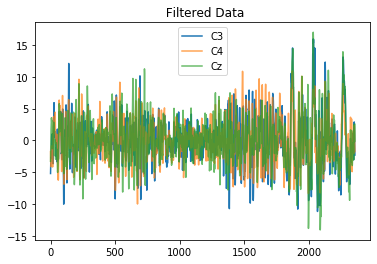

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Plot after filtering with a butter bandpass (ignore normalization)
plt.figure()
plt.clf()
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
plt.legend()
plt.title(" Filtered Data")

## EEG band visualization

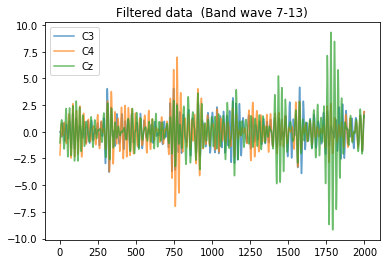

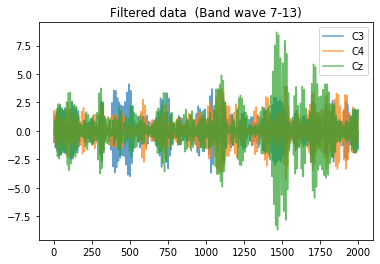

In [0]:
# determine the trial that we wish to plot
n_trial = 120
# now specify the alpha and beta cutoff frequencies
lo_a, lo_b = 7, 16
hi_a, hi_b = 13, 24

# first step is to filter the data
flt_a = gumpy.signal.butter_bandpass(grazb_data, lo=lo_a, hi=hi_a)
flt_b = gumpy.signal.butter_bandpass(grazb_data, lo=lo_b, hi=hi_b)

# finally we can visualize the data
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_a, hi_a)

## Extract Trials

In [0]:
# retrieve the trials from the filtered data. This requires that the function
# knows the number of trials, labels, etc. when only passed a (filtered) data matrix
trials = grazb_data.trials
labels = grazb_data.labels
sampling_freq = grazb_data.sampling_freq
data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)

# it is also possible to pass an instance of Dataset and filtered data.
# gumpy will then infer all necessary details from the dataset
data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)

# similar to other functions, this one allows to pass an entire instance of Dataset
# to operate on the raw data
data_class1 = gumpy.utils.extract_trials(grazb_data)

## Visualize Classes

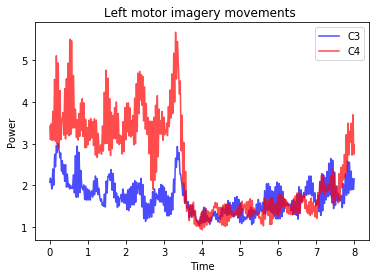

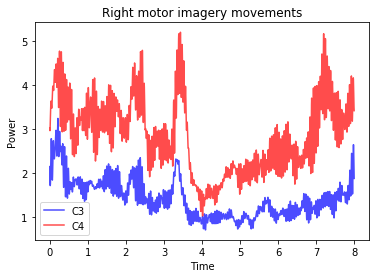

In [0]:
# specify some cutoff values for the visualization
lowcut_a, highcut_a = 14, 30
# and also an interval to display
interval_a = [0, 8]
# visualize logarithmic power?
logarithmic_power = False

# visualize the extracted trial from above
gumpy.plot.average_power(data_class_a, lowcut_a, highcut_a, interval_a, grazb_data.sampling_freq, logarithmic_power)

## Wavelet Transform

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cd16e44e0>,
      dtype=object)

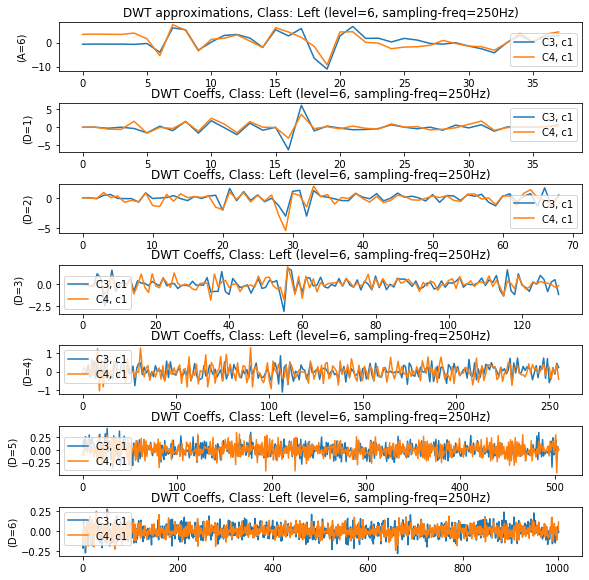

In [0]:
# As with most functions, you can pass arguments to a 
# gumpy function that will be forwarded to the backend.
# In this example the decomposition levels are mandatory, and the 
# mother wavelet that should be passed is optional
level = 6
wavelet = 'db4'

# now we can retrieve the dwt for the different channels
mean_coeff_ch0_c1 = gumpy.signal.dwt(data_class1[0], level=level, wavelet=wavelet)
mean_coeff_ch1_c1 = gumpy.signal.dwt(data_class1[1], level=level, wavelet=wavelet)
mean_coeff_ch0_c2 = gumpy.signal.dwt(data_class1[3], level=level, wavelet=wavelet)
mean_coeff_ch1_c2 = gumpy.signal.dwt(data_class1[4], level=level, wavelet=wavelet)

# gumpy's signal.dwt function returns the approximation of the 
# coefficients as first result, and all the coefficient details as list
# as second return value (this is contrast to the backend, which returns
# the entire set of coefficients as a single list)
approximation_C3 = mean_coeff_ch0_c2[0]
approximation_C4 = mean_coeff_ch1_c2[0]

# as mentioned in the comment above, the list of details are in the second
# return value of gumpy.signal.dwt. Here we save them to additional variables
# to improve clarity
details_c3_c1 = mean_coeff_ch0_c1[1]
details_c4_c1 = mean_coeff_ch1_c1[1]
details_c3_c2 = mean_coeff_ch0_c2[1]
details_c4_c2 = mean_coeff_ch1_c2[1]

# gumpy exhibits a function to plot the dwt results. You must pass three lists,
# i.e. the labels of the data, the approximations, as well as the detailed coeffs,
# so that gumpy can automatically generate appropriate titles and labels.
# you can pass an additional class string that will be incorporated into the title.
# the function returns a matplotlib axis object in case you want to further
# customize the plot.
gumpy.plot.dwt(
    [approximation_C3, approximation_C4],
    [details_c3_c1, details_c4_c1],
    ['C3, c1', 'C4, c1'],
    level, grazb_data.sampling_freq, 'Class: Left')

## DWT reconstruction and visualization

([array([ 5.21503658e-07,  1.61819012e-06,  3.04630780e-06, ...,
          3.08312365e-12,  1.59095105e-12, -5.12725164e-13]),
  array([ 1.43090770e-07,  4.44000857e-07,  8.35849420e-07, ...,
         -2.05427255e-11, -1.06004411e-11,  3.41626658e-12])],
 <Figure size 432x288 with 1 Axes>)

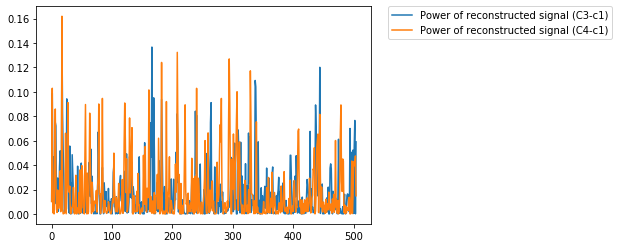

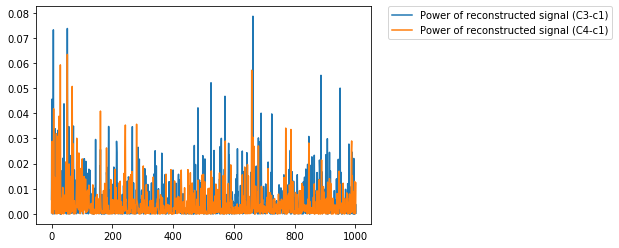

In [0]:
gumpy.plot.reconstruct_without_approx(
    [details_c3_c2[4], details_c4_c2[4]], 
    ['C3-c1', 'C4-c1'], level=6)

gumpy.plot.reconstruct_without_approx(
    [details_c3_c1[5], details_c4_c1[5]], 
    ['C3-c1', 'C4-c1'], level=6)

([array([-0.04379641,  0.17916636, -0.15634663, ...,  0.05339261,
         -0.05486782,  0.01305731]),
  array([-0.01783179,  0.0415965 , -0.07318729, ...,  0.03480512,
         -0.01006542,  0.00087816])],
 <Figure size 432x288 with 1 Axes>)

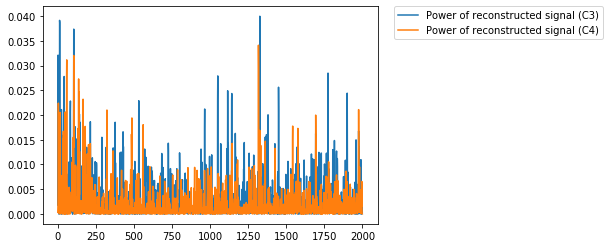

In [0]:
gumpy.plot.reconstruct_with_approx(
    [details_c3_c1[5], details_c4_c1[5]],
    ['C3', 'C4'], wavelet=wavelet)

## Welch's Power Spectral Density estimate

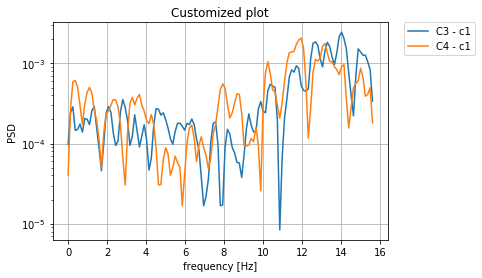

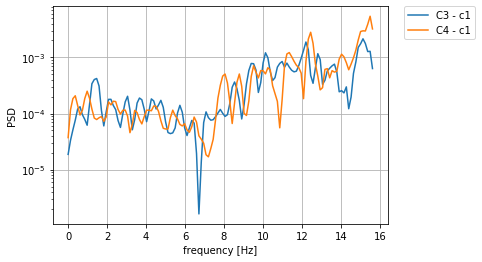

In [0]:
# the function gumpy.plot.welch_psd returns the power densities as 
# well as a handle to the figure. You can also pass a figure in if you 
# wish to modify the plot
fig = plt.figure()
plt.title('Customized plot')
ps, fig = gumpy.plot.welch_psd(
    [details_c3_c1[4], details_c3_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq, fig=fig)

ps, fig = gumpy.plot.welch_psd(
    [details_c4_c1[4], details_c4_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq)

## Alpha and Beta subbands

In [0]:
def alpha_subBP_features(data):
    # filter data in sub-bands by specification of low- and high-cut frequencies
    alpha1 = gumpy.signal.butter_bandpass(data, 8.5, 11.5, order=6)
    alpha2 = gumpy.signal.butter_bandpass(data, 9.0, 12.5, order=6)
    alpha3 = gumpy.signal.butter_bandpass(data, 9.5, 11.5, order=6)
    alpha4 = gumpy.signal.butter_bandpass(data, 8.0, 10.5, order=6)

    # return a list of sub-bands
    return [alpha1, alpha2, alpha3, alpha4]

alpha_bands = np.array(alpha_subBP_features(grazb_data))

In [0]:
def beta_subBP_features(data):
    beta1 = gumpy.signal.butter_bandpass(data, 14.0, 30.0, order=6)
    beta2 = gumpy.signal.butter_bandpass(data, 16.0, 17.0, order=6)
    beta3 = gumpy.signal.butter_bandpass(data, 17.0, 18.0, order=6)
    beta4 = gumpy.signal.butter_bandpass(data, 18.0, 19.0, order=6)
    return [beta1, beta2, beta3, beta4]

beta_bands = np.array(beta_subBP_features(grazb_data))

## Feature extraction using subbands

### Method 1: using log sub-band power

In [0]:
def powermean(data, trial, fs, w):
    return np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],0],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],1],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],2],2).mean()

def log_subBP_feature_extraction(alpha, beta, trials, fs, w):
    # number of features combined for all trials
    n_features = 15
    # initialize the feature matrix
    X = np.zeros((len(trials), n_features))
    
    # Extract features
    for t, trial in enumerate(trials):
        power_c31, power_c41, power_cz1 = powermean(alpha[0], trial, fs, w)
        power_c32, power_c42, power_cz2 = powermean(alpha[1], trial, fs, w)
        power_c33, power_c43, power_cz3 = powermean(alpha[2], trial, fs, w)
        power_c34, power_c44, power_cz4 = powermean(alpha[3], trial, fs, w)
        power_c31_b, power_c41_b, power_cz1_b = powermean(beta[0], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_c31), np.log(power_c41), np.log(power_cz1),
             np.log(power_c32), np.log(power_c42), np.log(power_cz2),
             np.log(power_c33), np.log(power_c43), np.log(power_cz3), 
             np.log(power_c34), np.log(power_c44), np.log(power_cz4),
             np.log(power_c31_b), np.log(power_c41_b), np.log(power_cz1_b)])

    return X

In [0]:
w1 = [0,125]
w2 = [125,250]

features1 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w1)

features2 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w2)                                          

# concatenate the features and normalize the data
features = np.concatenate((features1.T, features2.T)).T
features -= np.mean(features)
features = gumpy.signal.normalize(features, 'min_max')

# print shape to quickly check if everything is as expected
features.shape

(324, 30)

### Method 2: DWT

In [0]:
def dwt_features(data, trials, level, sampling_freq, w, n, wavelet): 
    import pywt
    
    # number of features per trial
    n_features = 9 
    # allocate memory to store the features
    X = np.zeros((len(trials), n_features))

    # Extract Features
    for t, trial in enumerate(trials):
        signals = data[trial + fs*4 + (w[0]) : trial + fs*4 + (w[1])]
        coeffs_c3 = pywt.wavedec(data = signals[:,0], wavelet=wavelet, level=level)
        coeffs_c4 = pywt.wavedec(data = signals[:,1], wavelet=wavelet, level=level)
        coeffs_cz = pywt.wavedec(data = signals[:,2], wavelet=wavelet, level=level)

        X[t, :] = np.array([
            np.std(coeffs_c3[n]), np.mean(coeffs_c3[n]**2),  
            np.std(coeffs_c4[n]), np.mean(coeffs_c4[n]**2),
            np.std(coeffs_cz[n]), np.mean(coeffs_cz[n]**2), 
            np.mean(coeffs_c3[n]),
            np.mean(coeffs_c4[n]), 
            np.mean(coeffs_cz[n])])
        
    return X

In [0]:
# We'll work with the data that was postprocessed using a butter bandpass
# filter further above

# to see it work, enable here. We'll use the log-power features further
# below, though
if False:
    w = [0, 256]
    
    # extract the features
    trials = grazb_data.trials
    fs = grazb_data.sampling_freq
    features1= np.array(dwt_features(btr_data, trials, 5, fs, w, 3, "db4"))
    features2= np.array(dwt_features(btr_data, trials, 5, fs, w, 4, "db4"))

    # concat the features and normalize
    features = np.concatenate((features1.T, features2.T)).T
    features -= np.mean(features)
    features = gumpy.signal.normalize(features, 'min_max')

## Sequential Feature Selection Algo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished

[2019-11-14 19:05:37] Features: 1/12 -- score: 0.5970216275659823[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished

[2019-11-14 19:05:40] Features: 2/12 -- score: 0.6277034457478006[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s finished

[2019-11-14 19:05:44] Features: 3/12 -- score: 0.6639601661779081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent 

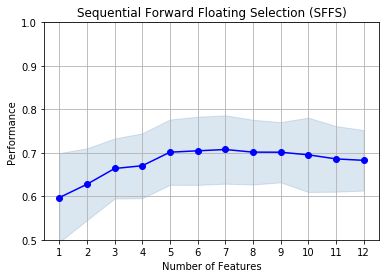

In [0]:
features_sel = gumpy.features.sequential_feature_selector(features, labels, 'LDA', (6, 12), 10, 'SFFS')


In [0]:
feature_idx, cv_scores, algorithm = features_sel[0], features_sel[1], features_sel[2]
print('Selection Algorithm: ', algorithm)
print('Average Score:       ', cv_scores * 100)
print('Feature Index:       ', feature_idx)

Selection Algorithm:  Sequential Forward Floating Selection (SFFS)
Average Score:        70.7646016617791
Feature Index:        (5, 7, 13, 14, 19, 23, 26)


## PCA

In [0]:
PCA = gumpy.features.PCA_dim_red(features, 0.95)


## Split data for training and classification

In [0]:
test_size = 0.2

## DOES NOT WORK
# if 1: 
#     split_features = np.array(gumpy.data.split(features, labels,test_size))
# if 0: 
#     n_splits=5
#     split_features = np.array(gumpy.data.variable_cross_validation(features, labels, n_splits)) 
# if 0: 
#     split_features = np.array(gumpy.data.split(PCA, labels, test_size))


## Gumpy doesn't have data.split so had to do it by hand
idx = np.arange(len(labels))
test_idx = np.random.choice(idx, int(np.floor(len(labels)*test_size)))
train_idx = [i for i in idx if i not in test_idx]

# the functions return a list with the data according to the following example
X_train = features[train_idx]
Y_train = labels[train_idx]
X_test = features[test_idx]
Y_test = labels[test_idx]

X_train.shape

(263, 30)

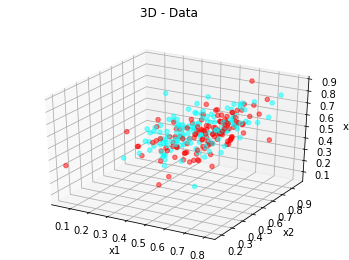

In [0]:
gumpy.plot.PCA("3D", features, X_train, Y_train)


# Decoding

## LDA

In [0]:
results, clf = gumpy.classify('LDA', X_train, Y_train, X_test, Y_test)


In [0]:
print("Classification results on test set:")
print(results)
print("Accuracy: ", results.accuracy)

Classification results on test set:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        36
           1       0.66      0.68      0.67        28

    accuracy                           0.70        64
   macro avg       0.70      0.70      0.70        64
weighted avg       0.70      0.70      0.70        64

Accuracy:  70.3125


## Confusion Matrix

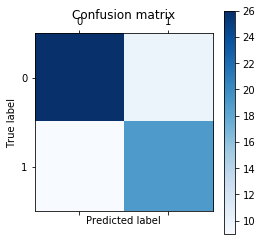

In [0]:
gumpy.plot.confusion_matrix(Y_test, results.pred)


## LSTM

In [0]:
# now that the dataset is setup, we can load the data. This will be handled from within the utils function, 
# which will first load the data and subsequently filter it using a notch and a bandpass filter.
# the utility function will then return the training data.
x_train, y_train = utils.load_preprocess_data(grazb_data, True, LOWCUT, HIGHCUT, W0, Q, ANTI_DRIFT, CLASS_COUNT, CUTOFF, AXIS, FS)

Band-pass filtering the data in frequency range from 2.0 Hz to 60.0 Hz... 
Data loaded and processed successfully!


In [0]:
#Augment Data
x_augmented, y_augmented = gumpy.signal.sliding_window(data = x_train[:,:,:],
                                                          labels = y_train[:,:],
                                                          window_sz = 4 * FS,
                                                          n_hop = FS // 10,
                                                          n_start = FS * 1)
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)

In [0]:
x_augmented[:, :, :].shape

(10199, 1000, 3)

In [0]:
np.savetxt("B02T_x_0channel.csv", x_augmented[:, :, 0], delimiter=",")

In [0]:
from google.colab import files
files.download('B02T_x_0channel.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 36992, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Testing capacity of 3 layer nn

In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
model = Sequential()
model.add(Dense(408, input_dim = 2, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [180]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 408)               1224      
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 818       
Total params: 2,042
Trainable params: 2,042
Non-trainable params: 0
_________________________________________________________________


In [0]:
np.random.seed(48)
x = np.random.randint(0, 1001, [1000, 2])
y = np.random.randint(0, 2, 1000)

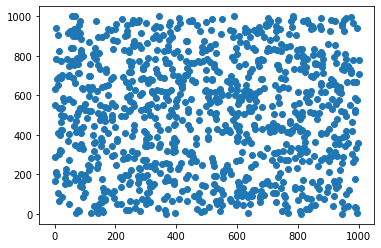

In [187]:
plt.scatter(x[:, 0], x[:, 1])

In [190]:
from keras.utils import to_categorical
y_binary = to_categorical(y)
y_binary

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [191]:
history = model.fit(x, y_binary, epochs = 100)

Epoch 1/100
1000/1000 [==============================] - 1s 890us/step - loss: 7.0858 - acc: 0.5080
Epoch 2/100
1000/1000 [==============================] - 0s 54us/step - loss: 7.3429 - acc: 0.5090
Epoch 3/100
1000/1000 [==============================] - 0s 49us/step - loss: 7.3485 - acc: 0.5070
Epoch 4/100
1000/1000 [==============================] - 0s 51us/step - loss: 4.6999 - acc: 0.4860
Epoch 5/100
1000/1000 [==============================] - 0s 55us/step - loss: 3.7590 - acc: 0.5030
Epoch 6/100
1000/1000 [==============================] - 0s 47us/step - loss: 1.7014 - acc: 0.5010
Epoch 7/100
1000/1000 [==============================] - 0s 48us/step - loss: 3.9576 - acc: 0.4660
Epoch 8/100
1000/1000 [==============================] - 0s 50us/step - loss: 2.9195 - acc: 0.5240
Epoch 9/100
1000/1000 [==============================] - 0s 52us/step - loss: 1.9760 - acc: 0.4930
Epoch 10/100
1000/1000 [==============================] - 0s 53us/step - loss: 1.4128 - acc: 0.4930
Epoch 11

Text(0.5, 1.0, 'Model - No Dropout')

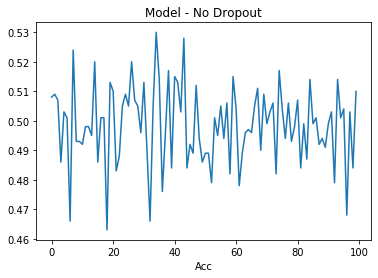

In [192]:
plt.plot(history.history['acc'])
plt.xlabel('Acc')
plt.title('Model - No Dropout')

In [0]:
from keras.layers import Dropout
model_do = Sequential()
model_do.add(Dense(408, input_dim = 2, activation = 'relu'))
model_do.add(Dropout(0.5))
model_do.add(Dense(2, activation = 'softmax'))
model_do.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [196]:
model_do.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 408)               1224      
_________________________________________________________________
dropout_9 (Dropout)          (None, 408)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 818       
Total params: 2,042
Trainable params: 2,042
Non-trainable params: 0
_________________________________________________________________


In [198]:
history = model_do.fit(x, y_binary, epochs = 100)

Epoch 1/100
1000/1000 [==============================] - 0s 77us/step - loss: 7.9330 - acc: 0.4990
Epoch 2/100
1000/1000 [==============================] - 0s 69us/step - loss: 7.7986 - acc: 0.4960
Epoch 3/100
1000/1000 [==============================] - 0s 62us/step - loss: 7.6159 - acc: 0.4970
Epoch 4/100
1000/1000 [==============================] - 0s 67us/step - loss: 7.3103 - acc: 0.5070
Epoch 5/100
1000/1000 [==============================] - 0s 62us/step - loss: 7.7727 - acc: 0.4940
Epoch 6/100
1000/1000 [==============================] - 0s 67us/step - loss: 7.9269 - acc: 0.4930
Epoch 7/100
1000/1000 [==============================] - 0s 63us/step - loss: 7.8635 - acc: 0.5090
Epoch 8/100
1000/1000 [==============================] - 0s 68us/step - loss: 7.9126 - acc: 0.5030
Epoch 9/100
1000/1000 [==============================] - 0s 66us/step - loss: 7.9534 - acc: 0.5050
Epoch 10/100
1000/1000 [==============================] - 0s 59us/step - loss: 7.8679 - acc: 0.5110
Epoch 11/

Text(0.5, 1.0, 'Model - Dropout')

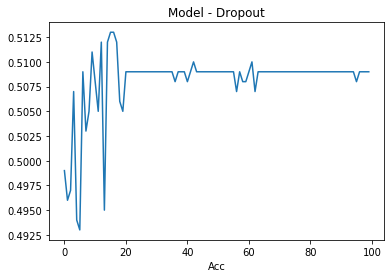

In [199]:
plt.plot(history.history['acc'])
plt.xlabel('Acc')
plt.title('Model - Dropout')

In [0]:
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_split, batch_size, monitor_index):
    # save best weights
    if os.path.isdir('logs'):
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
      os.mkdir('logs')
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    checkpointer = ModelCheckpoint('checkpoints/' + '%s.h5'%model_name, monitor=monitor_index, verbose=1,save_best_only=True, mode='auto', period=1)
    
    # stop if the model does not improve for 15 epoches
    stoppointer = EarlyStopping(monitor=monitor_index, min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_split = val_split,
                   callbacks=[checkpointer,stoppointer], verbose=2)
    return history


#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    model_json = model.to_json()
    if os.path.isdir('models'):
      # save model to json
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)
    else:
      os.mkdir('models')
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)

# draw the training curves
def draw_graphs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

Run 1...
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 128)               578048    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 258       
Total params: 578,306
Trainable params: 578,306
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 13s - loss: 0.7407 - acc: 0.5208 - val_loss: 0.8842 - val_acc: 0.3644

Epoch 00001: val_loss improved from inf to 0.88423, saving model to checkpoints/GRAZ_LSTM__run_1.h5
Epoch 2/100
 - 3s - loss: 0.5654 - acc: 0.7201 - val_loss: 0.9253 - val_acc: 0.3433

Epoch 00002: val_loss did not improve from 0.88423
Epoch 3/100
 - 3s - loss: 0.4675 - acc: 0.8216 - val_loss: 0.9885 - val_acc: 0.3346

Epoch 00003: val_loss did not improve fro

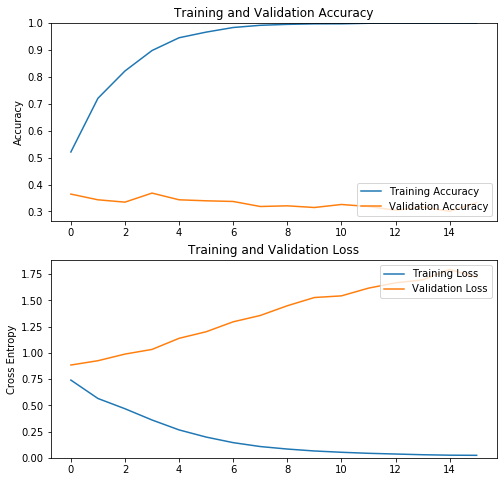

Evaluating model on test set...
Result on test set: 54.26%
Run 2...
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 128)               578048    
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 258       
Total params: 578,306
Trainable params: 578,306
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 14s - loss: 0.7302 - acc: 0.5236 - val_loss: 0.9076 - val_acc: 0.3234

Epoch 00001: val_loss improved from inf to 0.90763, saving model to checkpoints/GRAZ_LSTM__run_2.h5
Epoch 2/100
 - 3s - loss: 0.5634 - acc: 0.7158 - val_loss: 0.9047 - val_acc: 0.3582

Epoch 00002: val_loss improved from 0.90763 to 0.90467, saving model to checkpoints/GRAZ_LSTM__run_2.h5
Epoch 3/100
 -

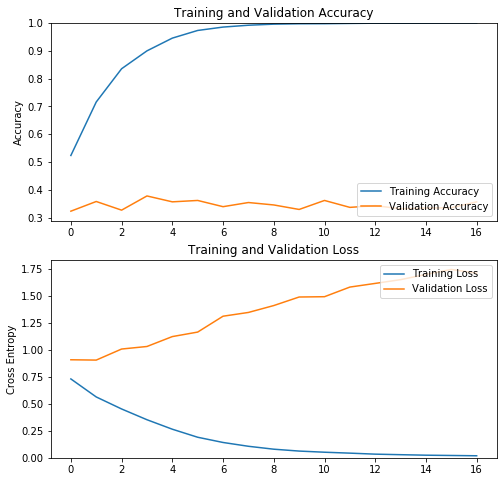

Evaluating model on test set...
Result on test set: 53.56%
Run 3...
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 128)               578048    
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 258       
Total params: 578,306
Trainable params: 578,306
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 13s - loss: 0.7282 - acc: 0.5221 - val_loss: 0.8524 - val_acc: 0.3781

Epoch 00001: val_loss improved from inf to 0.85245, saving model to checkpoints/GRAZ_LSTM__run_3.h5
Epoch 2/100
 - 2s - loss: 0.5623 - acc: 0.7234 - val_loss: 0.8823 - val_acc: 0.3657

Epoch 00002: val_loss did not improve from 0.85245
Epoch 3/100
 - 3s - loss: 0.4574 - acc: 0.8285 - val_loss: 0.9321 -

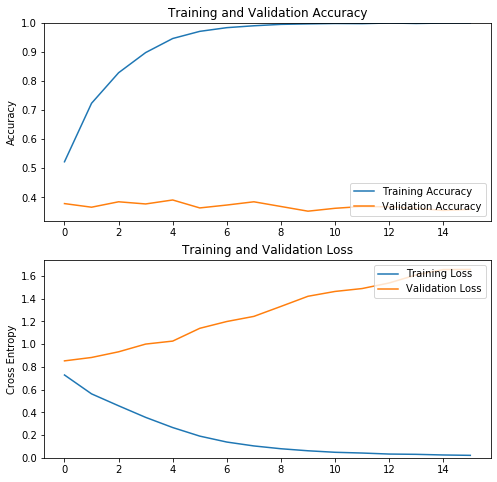

Evaluating model on test set...
Result on test set: 53.31%
Run 4...
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 128)               578048    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 258       
Total params: 578,306
Trainable params: 578,306
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 12s - loss: 0.7469 - acc: 0.5085 - val_loss: 0.8736 - val_acc: 0.3657

Epoch 00001: val_loss improved from inf to 0.87365, saving model to checkpoints/GRAZ_LSTM__run_4.h5
Epoch 2/100
 - 3s - loss: 0.5623 - acc: 0.7276 - val_loss: 0.9214 - val_acc: 0.3122

Epoch 00002: val_loss did not improve from 0.87365
Epoch 3/100
 - 2s - loss: 0.4576 - acc: 0.8278 - val_loss: 0.9866 -

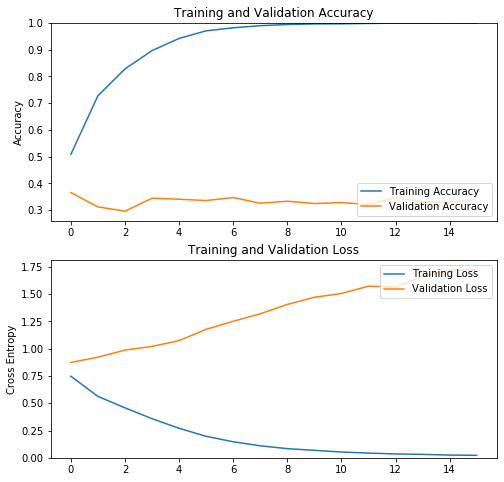

Evaluating model on test set...
Result on test set: 54.85%
Run 5...
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 128)               578048    
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 258       
Total params: 578,306
Trainable params: 578,306
Non-trainable params: 0
_________________________________________________________________
None
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 14s - loss: 0.7346 - acc: 0.5205 - val_loss: 0.8649 - val_acc: 0.3669

Epoch 00001: val_loss improved from inf to 0.86494, saving model to checkpoints/GRAZ_LSTM__run_5.h5
Epoch 2/100
 - 3s - loss: 0.5679 - acc: 0.7204 - val_loss: 0.9013 - val_acc: 0.3346

Epoch 00002: val_loss did not improve from 0.86494
Epoch 3/100
 - 3s - loss: 0.4642 - acc: 0.8241 - val_loss: 0.9776 -

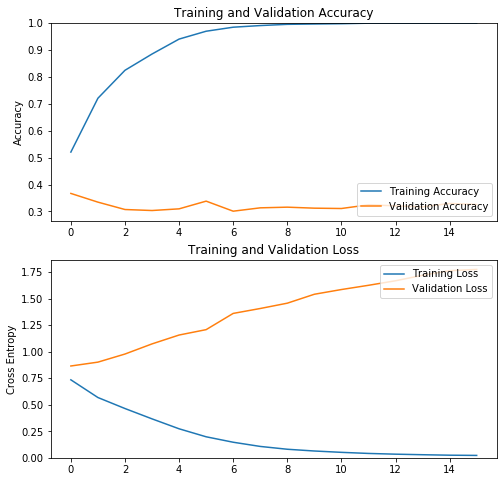

Evaluating model on test set...
Result on test set: 51.89%
53.57% (+/- 1.00%)
Saving CV values to file....
CV values successfully saved!



In [0]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores = []
history = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_LSTM_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    model = LSTM(model_name_str)
    model.create_model(x_subject.shape[1:], dropout = DROPOUT, print_summary = True)
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model.model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model.model, model_name_str, '')
    draw_graphs(h)
    history.append(h)

    history.append(h)
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
print ("cv accuracy is:", np.mean(cvscores))
print ("cv std is:", np.std(cvscores))

cv accuracy is: 53.57410576781719
cv std is: 0.9998712810000046


In [0]:
from google.colab import files
files.download('GRAZ_CV_LSTM_0.2do.csv')
for i in range(1, 6):
  files.download('GRAZ_LSTM__run_%s.csv'%i)